**Before running this example, install the required packages:**

In [1]:
!rm -rf ./*

In [2]:
# Install nuclab from TestPyPI, curie, and xlsxwriter
!pip install -i https://test.pypi.org/simple/ nuclab==0.0.6
!pip install curie
!pip install -q xlsxwriter

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: nuclab
    Found existing installation: nuclab 0.0.5
    Uninstalling nuclab-0.0.5:
      Successfully uninstalled nuclab-0.0.5


## **Notebook Overview**

In this noteobook, we demostrate how to use **nuclab's** ``Calibration`` and ``Serial`` classes together to perform the energy calibration of an HPGe detector and automate the analysis of serial measurments. The workflow guides you through determining ``efficiency_fit_params`` and ``detector_eff_uncertainty`` for a detector efficiency function of arbitrary form and variable count, providing a flexible framework adaptable to a range of detector charecteristics. These computed values are then applied to determine end-of-bombarmdent (EoB) activities using two complementary methods, as well of the half-lives of specified isotopes.

All examples are run on on **real experimental data provided in this project’s GitHub repository**, which will be automatically imported when executing the notebook.

## Import Dependencies

- The **nuclab** package relies on **curie** which is used for peak fitting and extraction of net peak areas from ``.Spe`` files.

- We use the ``Calibration ``class from **nuclab's** ``calibration`` module.

- We use the ``Serial`` class from **nuclab's** ``serial`` module.

In [3]:
import nuclab
from nuclab.calibration import Calibration
from nuclab.serial import Serial

import curie as ci

# Standard data handling tools
import pandas as pd
import numpy as np

# For defining EoB timestamps
from datetime import datetime

# For eff_func definition
import math
# To download and extract example data from GitHub
import os, urllib.request, zipfile

## Extract Example Data From Project Repository

In this code block, we download the calibration spectra and serial HPGe measurment ``.Spe``files from the project repository. These files are extracted into the ``example_data`` directory, which provides all the data needed to run through the workflow described above.

In [4]:
# Make local dir
os.makedirs("data", exist_ok=True)

# Direct URL to example_data.zip in your repo
zip_url = "https://github.com/vivektara24/Separation-of-terbium-from-proton-irradiated-gadolinium-oxide-targets/raw/main/example_data.zip"
zip_path = "example_data.zip"

# Download ZIP
urllib.request.urlretrieve(zip_url, zip_path)

# Extract contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

# Path to extracted folder
data_dir = "example_data"
print("Files in example_data:", os.listdir(data_dir))

Files in example_data: ['yield', 'cal-to-ser']


# Calibration-to-Serial Workflow

In [5]:
# Define directory where outputs of the nuclab package will be saved
# Will be created automatically during the workflow
output_dir = 'outputs'

## Detector Calibration Workflow

In this section we use the ``Calibration`` class from the ``calibration`` module of **nuclab** to determine the detector's ``efficiency_fit_params`` and ``detector_eff_uncertainty``. These paremeters are essential for analyzing serial HPGe measurments.

In [6]:
# Define the path to the calibration specturm
DATA_PATH = "/content/example_data/cal-to-ser/Calibration-Data/20250407_AmBaCoCsEuCalibLong_d1s200.Spe"

In [7]:
# Define end-of-bombardment time for the calibration sources
CAL_EOB_TIME = datetime(1984, 8, 1, 4, 00)

In [8]:
# Define the calibration gamma lines as a DataFrame.
# - Energy values must be in keV.
# - Intensities should be given as percentages (not fractions).


CAL_GAMMAS = pd.DataFrame({
    'energy': [59.5412, # 241Am

               80.9971, 276.7364, 302.853, 356.017, 383.851, # 133Ba

               121.7817, 244.6975, 344.2785, 778.904, 964.079, 1112.074, 1408.006, # 152Eu

               661.657,], # 137Cs

    'intensity': [35.9, # 241Am

                  32.9, 7.16, 18.34, 62.05, 8.94, # 133Ba

                  28.53, 7.55, 26.59, 12.93, 14.51, 13.67, 20.87, # 152Eu

                  85.10], # 137Cs

    'unc_intensity': [0.4, # 241Am

                      0.3, 0.05, 0.13, 0.0, 0.06,  # 133Ba

                      0.16, 0.04, 0.20, 0.08, 0.07, 0.08, 0.09, # 152Eu

                      0.20], # 137Cs

    'isotope': ['214AM', # 241Am

                '133BA', '133BA', '133BA', '133BA', '133BA', # 133Ba

                '152EU', '152EU', '152EU', '152EU', '152EU', '152EU', '152EU', # 152Eu

                '137CS'], # 137Cs

})

In [9]:
# Define the half-lives dictionary. Maps gamma lines to half-lives in (s)
CAL_HALF_LIVES = {

    # 241Am
    59.5412 : 432.6 * 365 * 24 * 60 * 60,

    # 133Ba
    80.9971: 10.536 * 365 * 24 * 60 * 60,
    276.7364: 10.536 * 365 * 24 * 60 * 60,
    302.853: 10.536 * 365 * 24 * 60 * 60,
    356.017: 10.536 * 365 * 24 * 60 * 60,
    383.851: 10.536 * 365 * 24 * 60 * 60,

    # 152Eu
    121.7817: 13.517 * 365 * 24 * 60 * 60,
    244.6975: 13.517 * 365 * 24 * 60 * 60,
    344.2785: 13.517 * 365 * 24 * 60 * 60,
    778.904: 13.517 * 365 * 24 * 60 * 60,
    964.079: 13.517 * 365 * 24 * 60 * 60,
    1112.074: 13.517 * 365 * 24 * 60 * 60,
    1408.006: 13.517 * 365 * 24 * 60 * 60,

    # 137Cs
    661.657: 30.007 * 365 * 24 * 60 * 60,


}

In [10]:
# Define the initial-activity dictionary
CAL_INITIAL_ACTIVITES = {

    # 241Am
    59.5412 : 11.42,

    # 133Ba
    80.9971: 11.09,
    276.7364: 11.09,
    302.853: 11.09,
    356.017: 11.09,
    383.851: 11.09,

    # 152Eu
    121.7817: 10,
    244.6975: 10,
    344.2785: 10,
    778.904: 10,
    964.079: 10,
    1112.074: 10,
    1408.006: 10,

    # 137Cs
    661.657: 11.93,

}

In [11]:
# Define the Form of the Efficiency Function
def EffFit(x,b1,b2,b3,b4,b5,b6):

    x = x/1000
    y = math.e**(b1*x**1+b2*x**0+b3*x**(-1)+b4*x**(-2)+b5*x**(-3)+b6*x**(-4))
    return y

In [12]:
# Instantiate the calibartion class
cb = Calibration(data_path=DATA_PATH, eob_time=CAL_EOB_TIME, gammas=CAL_GAMMAS,
                 half_lives=CAL_HALF_LIVES, calibration_eob_activities=CAL_INITIAL_ACTIVITES, eff_func=EffFit)

In [13]:
# Process the calibration spectrum file
# Returns ``peak_data``: DataFrame of peak fitting data sorted by gamma energy
cb.process_spectrum_file()

Reading Spectrum /content/example_data/cal-to-ser/Calibration-Data/20250407_AmBaCoCsEuCalibLong_d1s200.Spe
Finished fitting peaks for 20250407_AmBaCoCsEuCalibLong_d1s200.Spe


,filename,isotope,energy,counts,unc_counts,intensity,unc_intensity,decays,unc_decays,decay_rate,...,chi2,start_time,live_time,real_time,file,decay time (s),half-life (s),activity,detector efficiency,uncertainty detector efficiency
0,/content/example_data/cal-to-ser/Calibration-D...,214AM,59.5412,419694.717396,12363.184827,0.3590,0.0040,2.258604e+08,7.163268e+06,1009.404764,...,320.841992,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,1.364247e+10,395862.323810,0.000013,4.160742e-07
1,/content/example_data/cal-to-ser/Calibration-D...,133BA,80.9971,75810.960318,21323.708861,0.3290,0.0030,4.147250e+07,1.167316e+07,185.346963,...,1324.296948,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,3.322633e+08,28195.889488,0.000037,1.029085e-05
2,/content/example_data/cal-to-ser/Calibration-D...,152EU,121.7817,89218.692924,1186.899846,0.2853,0.0016,5.863418e+07,8.933954e+05,262.045179,...,6.617278,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,4.262721e+08,45890.978487,0.000030,4.401742e-07
3,/content/example_data/cal-to-ser/Calibration-D...,152EU,244.6975,13866.638056,3076.930225,0.0755,0.0004,4.892688e+07,1.086966e+07,218.661735,...,161.969614,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,4.262721e+08,45890.978487,0.000018,3.974541e-06
4,/content/example_data/cal-to-ser/Calibration-D...,133BA,276.7364,8015.851373,393.314292,0.0716,0.0005,3.313064e+07,1.687058e+06,148.065917,...,3.379479,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,3.322633e+08,28195.889488,0.000018,8.805163e-07
5,/content/example_data/cal-to-ser/Calibration-D...,133BA,302.8530,15952.223943,1671.895752,0.1834,0.0013,2.784830e+07,2.935139e+06,124.458337,...,63.242473,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,3.322633e+08,28195.889488,0.000014,1.449964e-06
6,/content/example_data/cal-to-ser/Calibration-D...,152EU,344.2785,33276.427165,2634.186713,0.2659,0.0020,4.483578e+07,3.577148e+06,200.377999,...,126.759085,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,4.262721e+08,45890.978487,0.000012,9.702248e-07
7,/content/example_data/cal-to-ser/Calibration-D...,133BA,356.0170,45039.515503,2837.182843,0.6205,0.0000,2.677569e+07,1.694072e+06,119.664684,...,126.759085,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,3.322633e+08,28195.889488,0.000012,7.256077e-07
8,/content/example_data/cal-to-ser/Calibration-D...,133BA,383.8510,5823.533827,151.902164,0.0894,0.0006,2.563880e+07,7.735429e+05,114.583732,...,0.968624,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,3.322633e+08,28195.889488,0.000010,2.784214e-07
9,/content/example_data/cal-to-ser/Calibration-D...,137CS,661.6570,185242.944556,795.520017,0.8510,0.0020,1.330985e+08,8.515161e+05,594.837554,...,3.638039,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,9.463008e+08,172389.294979,0.000006,2.765503e-08


#### Peak Fitting Data Manipulation

In this particular calibration spectrum it was observed the 80.9971	keV peak had unreprestative statistics. I can't remeber why. We briefly show if manipulation of the data returned by the peak fit is required, one can save the DataFrame to a csv and reload the adjusted peak fit data to the calibration object `cb`

In [14]:
cb.peak_data[cb.peak_data['energy'] == 80.9971]

,filename,isotope,energy,counts,unc_counts,intensity,unc_intensity,decays,unc_decays,decay_rate,...,chi2,start_time,live_time,real_time,file,decay time (s),half-life (s),activity,detector efficiency,uncertainty detector efficiency
1,/content/example_data/cal-to-ser/Calibration-D...,133BA,80.9971,75810.960318,21323.708861,0.329,0.003,4.147250e+07,1.167316e+07,185.346963,...,1324.296948,04/04/2025 18:00:27,223542.0,223756.0,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1.283609e+09,332263296.0,28195.889488,0.000037,0.00001


In [15]:
# Save raw peak fit/calibration data to csv for manipulation
cb.save_peak_data(f"{output_dir}/efficiency_peak_data.csv")

Peak data saved to outputs/efficiency_peak_data.csv


In [16]:
# Post data manipulation reload peak fit/calibration data.
cb.peak_data = pd.read_csv("/content/example_data/cal-to-ser/Calibration-Data/calibration-data-bq.csv")
cb.peak_data[cb.peak_data['energy'] == 80.9971]

,isotope,energy,counts,unc_counts,intensity,unc_intensity,start_time,live_time,real_time,file,decay time (s),half-life (s),activity,detector efficiency,uncertainty detector efficiency
1,133BA,80.9971,41334.0,609.922946,0.329,0.003,4/4/2025 18:00,223542,223756,20250407_AmBaCoCsEuCalibLong_d1s200.Spe,1283608827,332263296,28195.88949,0.00002,3.460000e-07


In [17]:
# Initial Parameter Estimates for the Curve-Fit Algorithm
p0 = [-0.306655,-7.80031,0.739484,-0.0959825,0.00513815,-0.00121]


Analyzing:   →  calibration-plot.png
Optimized Decay Parameters:
  Parameter 1: 0.0377 ± 0.0786
  Parameter 2: -13.3000 ± 0.1507
  Parameter 3: 0.9218 ± 0.0898
  Parameter 4: -0.0928 ± 0.0175
  Parameter 5: 0.0030 ± 0.0013
  Parameter 6: -0.0000 ± 0.0000

📐 Jacobian condition number: 3.04e+11


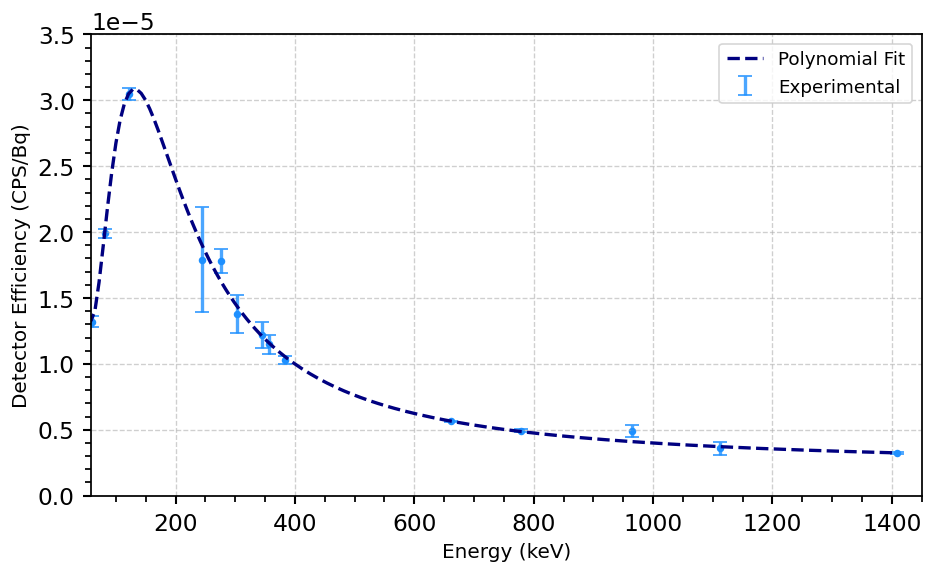

In [18]:
# Fit the per-line detector efficiency values to the defined efficiency function
# By default saves plot to plot_directory with name 'calibration-plot.png'
eff_fit_params, _ = cb.process_calibration_data(initial_guesses=p0, plot_directory=f'{output_dir}', xlim=(59, 1450), ylim=(0, 3.5e-5))

In [19]:
# Calculate the fractional uncertainty of the fitted function
detector_eff_uncertainty = cb.get_eff_fit_uncetainty()
print(f"The fractional uncertainty in the energy efficiency value returned by the efficiency function is: {detector_eff_uncertainty}")

The fractional uncertainty in the energy efficiency value returned by the efficiency function is: 0.08603454310973341


## Serial Measurment Analysis Pipleine

In this section we use the ``Serial`` class from the ``serial`` module of **nuclab** to perform to automate the analysis of 31 sequential 2-hour HPGe measurments. The pipeline produces an analysis-ready table containing:
- **End-of-bombardment (EoB) activites** for each specified isotope, determined in two ways:
  - By fitting an exponential decay function to the start of measurment
  - By averaging the decay corrected activites across the sequential measurments
- **Experimentally observed half-lives**, extracted from the curve fit.

Uncertainties are reported for all values. A detailed description of the uncertainty analysis is provided in the Supplemnetary infomration of [Reference/Paper]

In [20]:
# Define the path to the directory containing serial .Spe files.
DATA_DIR = "/content/example_data/cal-to-ser/2Hr-Data"

In [21]:
# Define end-of-bombardment timestamp for irradiation
SER_EOB_TIME = datetime(2025, 2, 21, 7, 58)  # YYYY, M, D, h, m

In [22]:
# Define gammas DataFrame
SER_GAMMAS = pd.DataFrame(
    {
        "energy": [
            344.2785, 586.27, 778.9045,  # 152Tb
            212.00,                      # 153Tb
            123.07, 1274.436, 1291.31,   # 154gTb
            540.18,                      # 154m1Tb
            426.78,                      # 154m2Tb
            105.318, 148.64, 180.08, 262.27,  # 155Tb
            534.29, 199.19, 1222.44      # 156Tb
        ],
        "intensity": [
            63.5, 9.21, 5.54,            # 152Tb
            28.5,                         # 153Tb
            26.0, 10.5, 6.9,              # 154gTb
            20.0,                         # 154m1Tb
            17.3,                         # 154m2Tb
            25.1, 2.65, 7.5, 5.3,         # 155Tb
            67.0, 41.0, 31.0              # 156Tb
        ],
        "unc_intensity": [
            1.7, 0.21, 0.13,             # 152Tb
            1.9,                          # 153Tb
            4.0, 0.8, 0.5,                # 154gTb
            3.0,                          # 154m1Tb
            1.2,                          # 154m2Tb
            1.3, 0.14, 0.4, 0.3,          # 155Tb
            6.0, 5.0, 3.0                 # 156Tb
        ],
        "isotope": [
            "152TB", "152TB", "152TB",
            "153TB",
            "154TB", "154TB", "154TB",
            "154TB",
            "154TB",
            "155TB", "155TB", "155TB", "155TB",
            "156TB", "156TB", "156TB",
        ],
    }
)

In [23]:
# Define half-lives dict
SER_HALF_LIVES = {
    344.2785: 17.5 * 60 * 60,
    586.27:   17.5 * 60 * 60,
    778.9045: 17.5 * 60 * 60,
    212.00:   2.34 * 24 * 60 * 60,
    123.07:   21.5 * 60 * 60,
    1274.436: 21.5 * 60 * 60,
    1291.31:  21.5 * 60 * 60,
    540.18:   9.4 * 60 * 60,
    426.78:   22.7 * 60 * 60,
    105.318:  5.32 * 24 * 60 * 60,
    148.64:   5.32 * 24 * 60 * 60,
    180.08:   5.32 * 24 * 60 * 60,
    262.27:   5.32 * 24 * 60 * 60,
    534.29:   5.35 * 24 * 60 * 60,
    199.19:   5.35 * 24 * 60 * 60,
    1222.44:  5.35 * 24 * 60 * 60,
}

In [28]:
# Instantiate the Serial class
# Use eff_fit_params from the Calibration class workflow
# Use detector_eff_uncertainty from the Calibration class workflow
se = Serial(data_directory=DATA_DIR, efficiency_fit_params=eff_fit_params, detector_eff_uncertianty=detector_eff_uncertainty, eob_time=SER_EOB_TIME, gammas=SER_GAMMAS, half_lives=SER_HALF_LIVES)

In [34]:
# Define distance from the face of the detector (cm) the calibration sources were
# placed when determining the efficiency fit parameters.
CALIBRATION_SLOT = 200

In [33]:
# Process the sequential spectrum files
se.process_spectrum_files(
    efficiency_func=EffFit,
    calibration_slot=CALIBRATION_SLOT,
    plot_dir=f'{output_dir}/peak_fit_plots'
)

Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-000.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-000.Spe
Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-001.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-001.Spe
Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-002.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-002.Spe
Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-003.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-003.Spe
Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-004.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-004.Spe
Reading Spectrum /content/example_data/cal-to-ser/2Hr-Data/120-Min-Decay-Report-d1s200-005.Spe
Finished fitting peaks for 120-Min-Decay-Report-d1s200-005.Spe
Reading Spectrum /content/example_data/cal-to-ser/2H

In [35]:
se.peak_data.head()

,isotope,energy,counts,unc_counts,intensity,unc_intensity,start_time,live_time,real_time,file,detector_slot,decay time (s),half-life (s),detector efficiency,activity,uncertainty activity,eob activity,uncertainty eob activity,ln(activity),uncertainty ln(activity)
0,155TB,105.318,85633.144206,1528.853313,0.2510,0.0130,02/21/2025 17:06:37,7200.0,7402.0,120-Min-Decay-Report-d1s200-000.Spe,200,32917.0,459648.0,0.000028,1.694086e+06,172790.030060,1.780300e+06,181583.544999,14.342654,0.101996
1,154TB,123.070,199528.492924,2394.571745,0.2600,0.0400,02/21/2025 17:06:37,7200.0,7402.0,120-Min-Decay-Report-d1s200-000.Spe,200,32917.0,77400.0,0.000031,3.594488e+06,635061.793264,4.826812e+06,852784.499042,15.094912,0.176677
2,155TB,148.640,7674.645181,856.106286,0.0265,0.0014,02/21/2025 17:06:37,7200.0,7402.0,120-Min-Decay-Report-d1s200-000.Spe,200,32917.0,459648.0,0.000030,1.343995e+06,202209.212115,1.412393e+06,212499.908441,14.111157,0.150454
3,155TB,180.080,23911.831132,411.228591,0.0750,0.0040,02/21/2025 17:06:37,7200.0,7402.0,120-Min-Decay-Report-d1s200-000.Spe,200,32917.0,459648.0,0.000027,1.676172e+06,172100.889507,1.761475e+06,180859.333164,14.332023,0.102675
4,156TB,199.190,126859.170440,885.876946,0.4100,0.0500,02/21/2025 17:06:37,7200.0,7402.0,120-Min-Decay-Report-d1s200-000.Spe,200,32917.0,462240.0,0.000024,1.791957e+06,267733.091905,1.882628e+06,281280.081217,14.398819,0.149408


In [36]:
print(f"Columns of peak_data DataFrame: {se.peak_data.columns}")

Columns of peak_data DataFrame: Index(['isotope', 'energy', 'counts', 'unc_counts', 'intensity',
       'unc_intensity', 'start_time', 'live_time', 'real_time', 'file',
       'detector_slot', 'decay time (s)', 'half-life (s)',
       'detector efficiency', 'activity', 'uncertainty activity',
       'eob activity', 'uncertainty eob activity', 'ln(activity)',
       'uncertainty ln(activity)'],
      dtype='object')


In [37]:
# Save enriched per-line peak fit data, sorted by decay time to xlsx
se.save_peak_data(
        filepath=f"{output_dir}/per-line-peak-data.xlsx",
        sort_key="decay time (s)",
        columns=[
            "file", "isotope", "energy", "decay time (s)",
            "counts", "unc_counts", "intensity", "unc_intensity",
            "detector efficiency", "activity", "uncertainty activity",
            "eob activity", "uncertainty eob activity",
        ],
        include_summary=True,
    )

'outputs/per-line-peak-data.xlsx'


Analyzing: 152TB @ 344.2785 keV  →  152TB_344.279_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 237197.6158 ± 18070.6029
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 3.93e+21


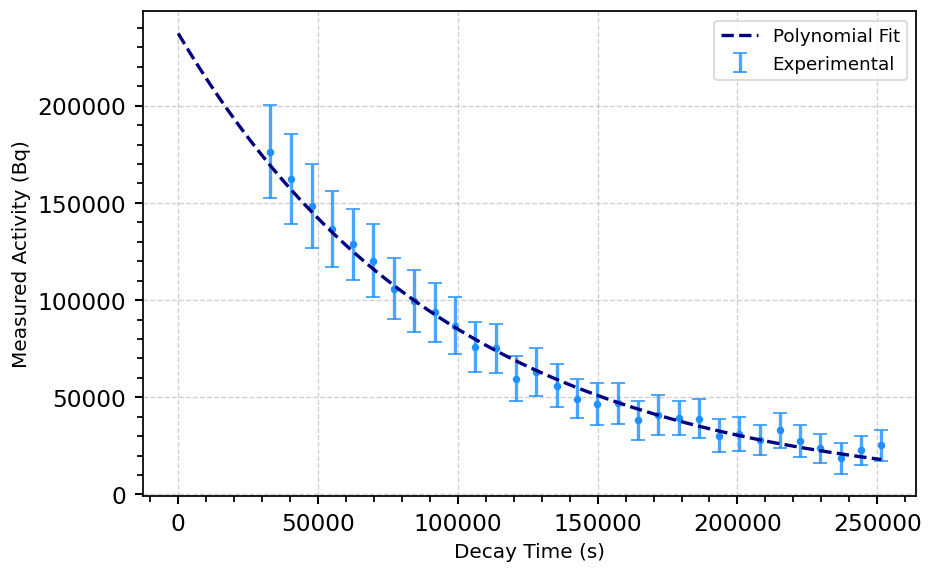


Analyzing: 153TB @ 212.0 keV  →  153TB_212.000_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 55832.9817 ± 5258.0483
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 4.89e+20


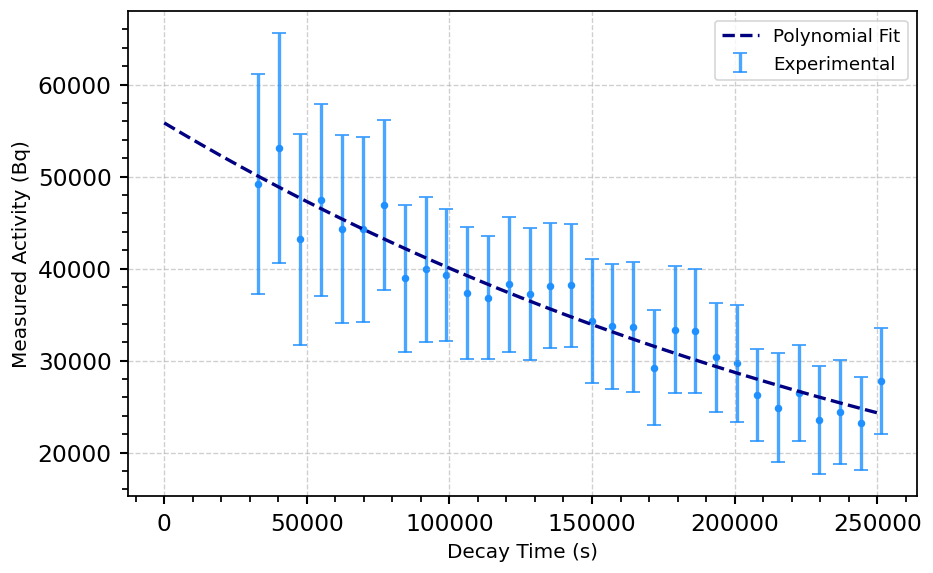


Analyzing: 154TB @ 123.07 keV  →  154TB_123.070_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 4887790.9971 ± 380019.1319
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 3.75e+24


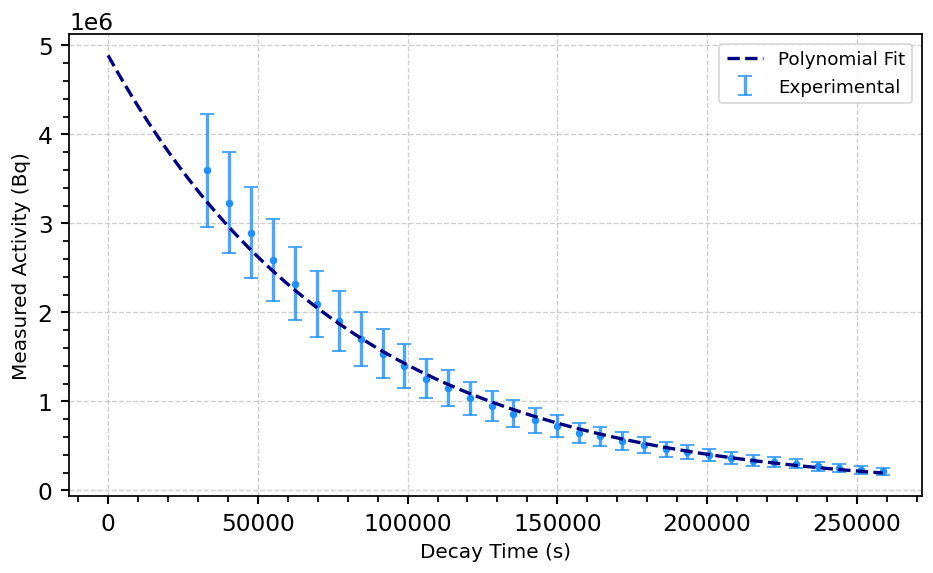


Analyzing: 154TB @ 426.78 keV  →  154TB_426.780_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 34597.2140 ± 118646.8376
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 6.17e+19


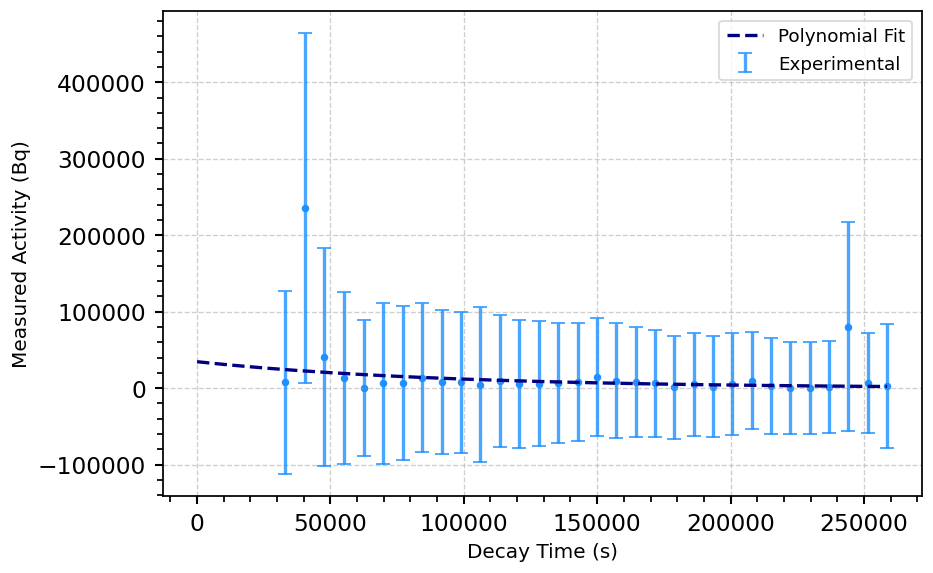


Analyzing: 154TB @ 540.18 keV  →  154TB_540.180_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 6695151.9989 ± 502650.4777
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 5.35e+24


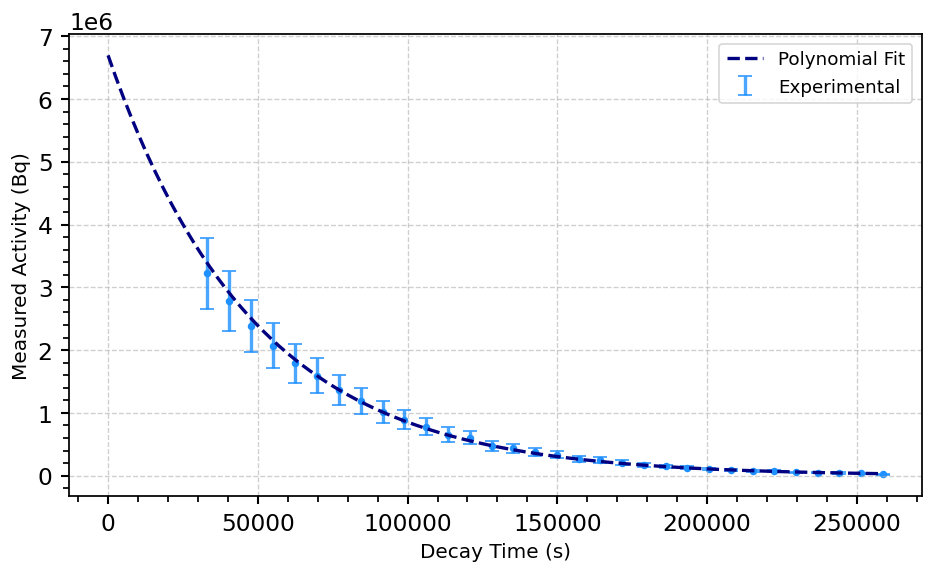


Analyzing: 154TB @ 1274.436 keV  →  154TB_1274.436_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 1369869.8569 ± 75967.7545
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 2.23e+23


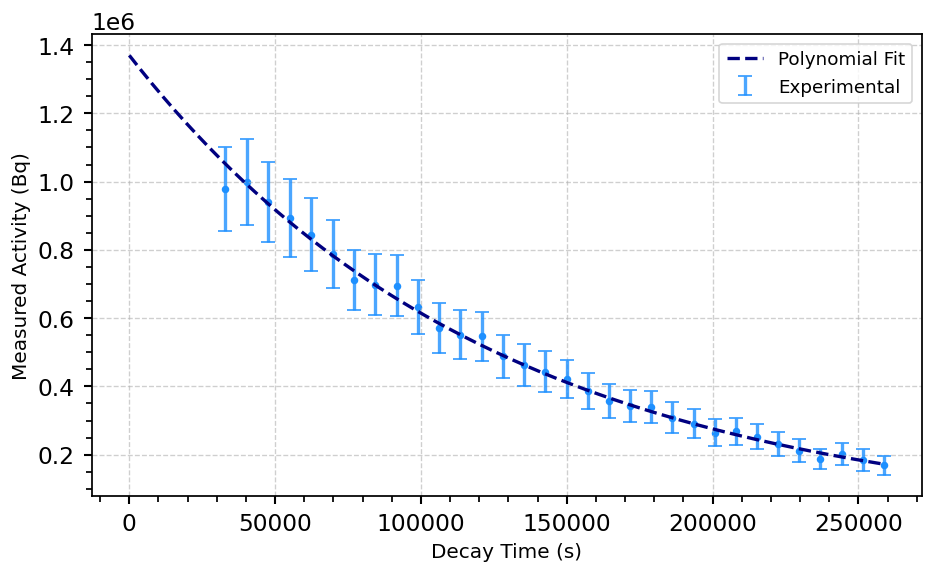


Analyzing: 154TB @ 1291.31 keV  →  154TB_1291.310_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 1559086.9560 ± 95021.0445
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 2.74e+23


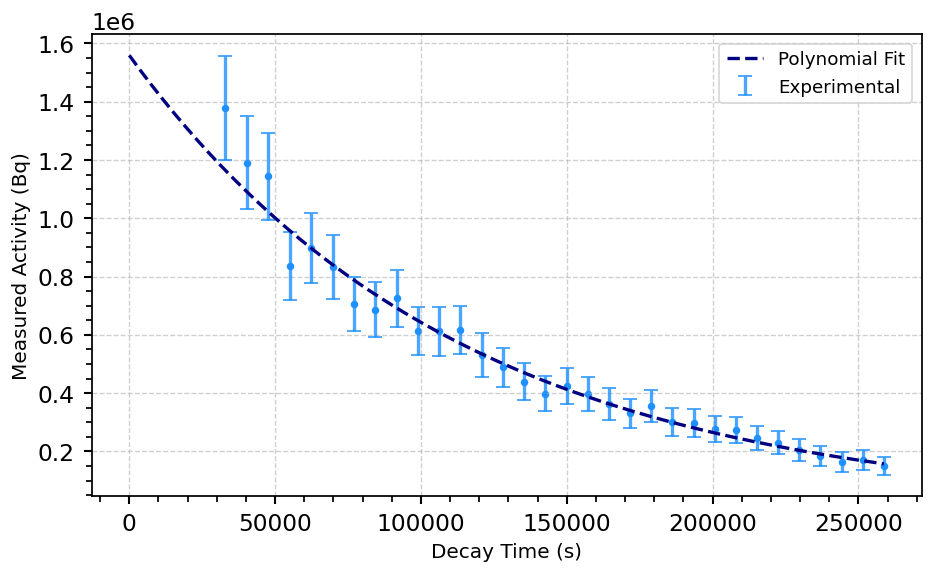


Analyzing: 155TB @ 105.318 keV  →  155TB_105.318_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 1789730.6763 ± 77101.2791
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 4.72e+23


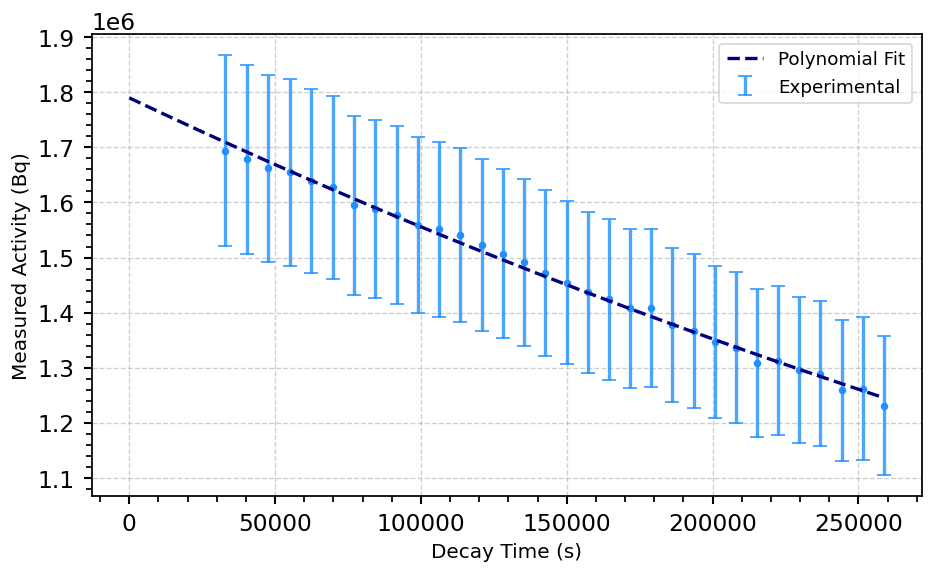


Analyzing: 155TB @ 148.64 keV  →  155TB_148.640_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 1530245.7924 ± 89193.2213
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 3.41e+23


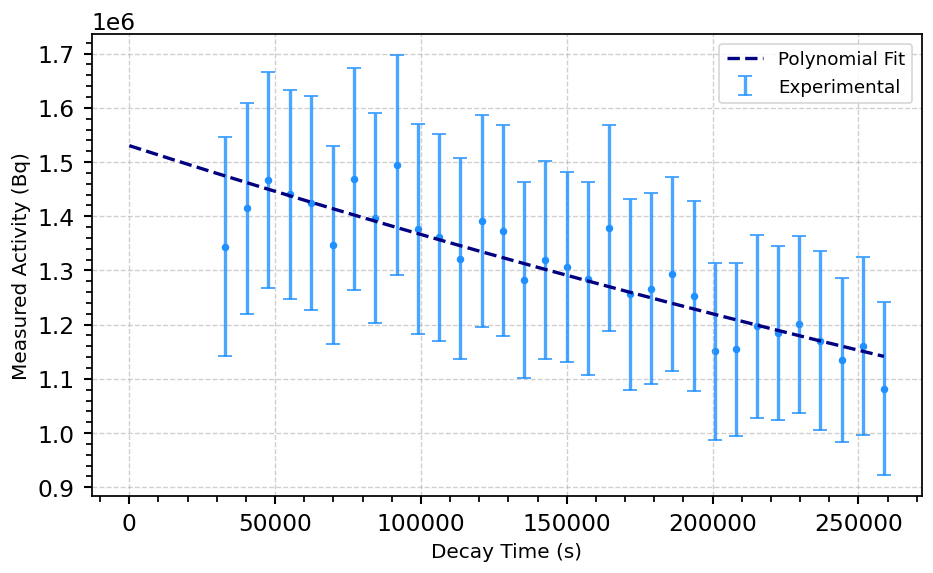


Analyzing: 155TB @ 180.08 keV  →  155TB_180.080_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 1792525.2437 ± 77710.1013
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 4.67e+23


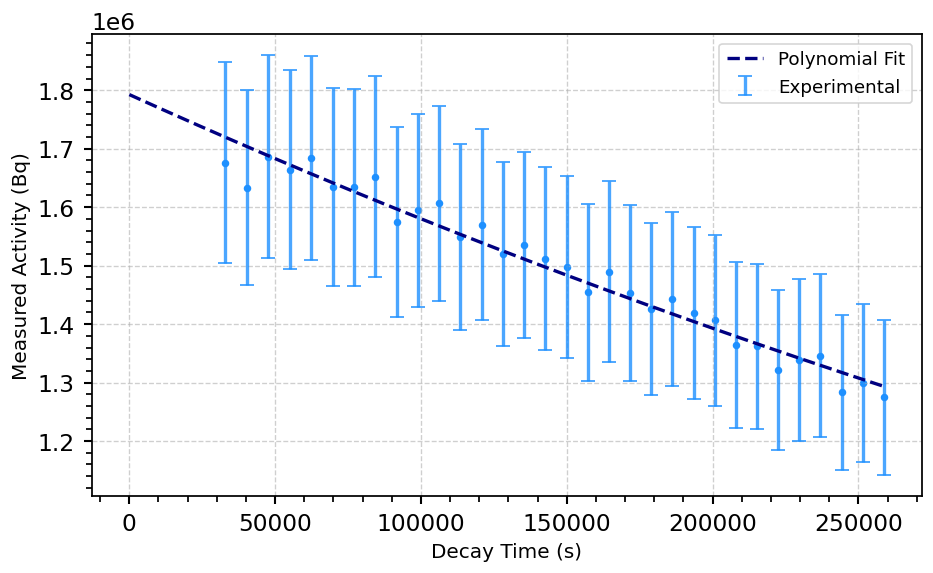


Analyzing: 155TB @ 262.27 keV  →  155TB_262.270_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 29641859.8473 ± 1794541.6612
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 2.30e+26


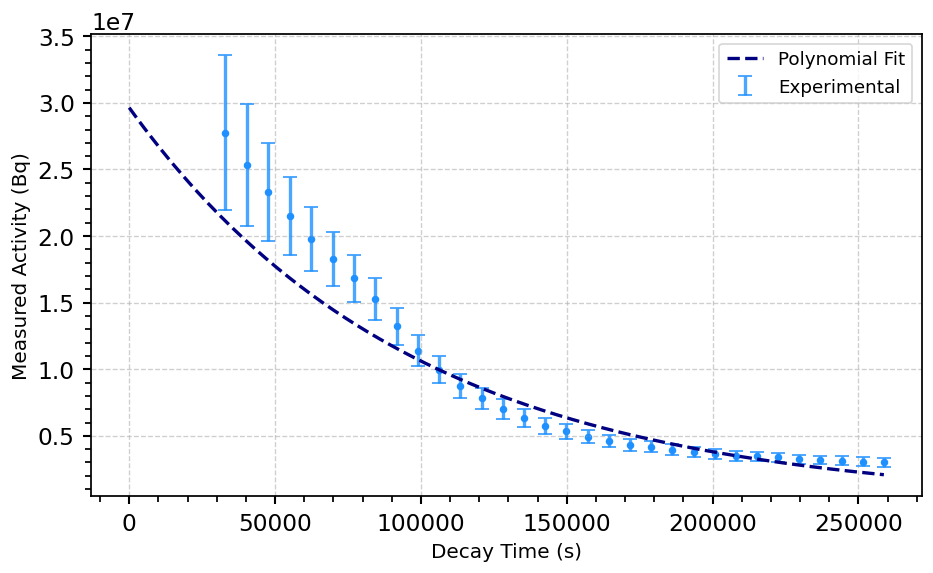


Analyzing: 156TB @ 199.19 keV  →  156TB_199.190_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 2009411.3933 ± 125210.4897
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 5.85e+23


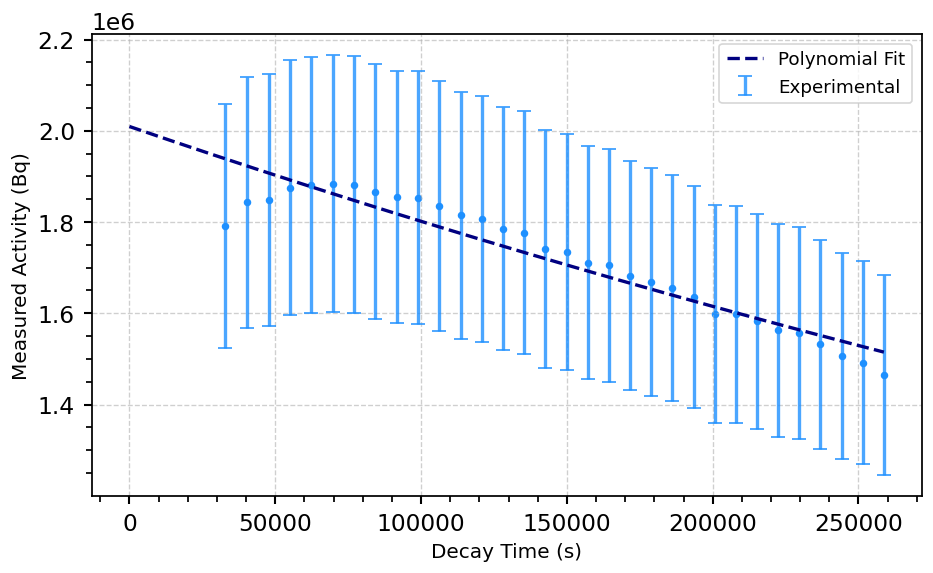


Analyzing: 156TB @ 534.29 keV  →  156TB_534.290_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 2296826.3157 ± 119128.6665
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 7.65e+23


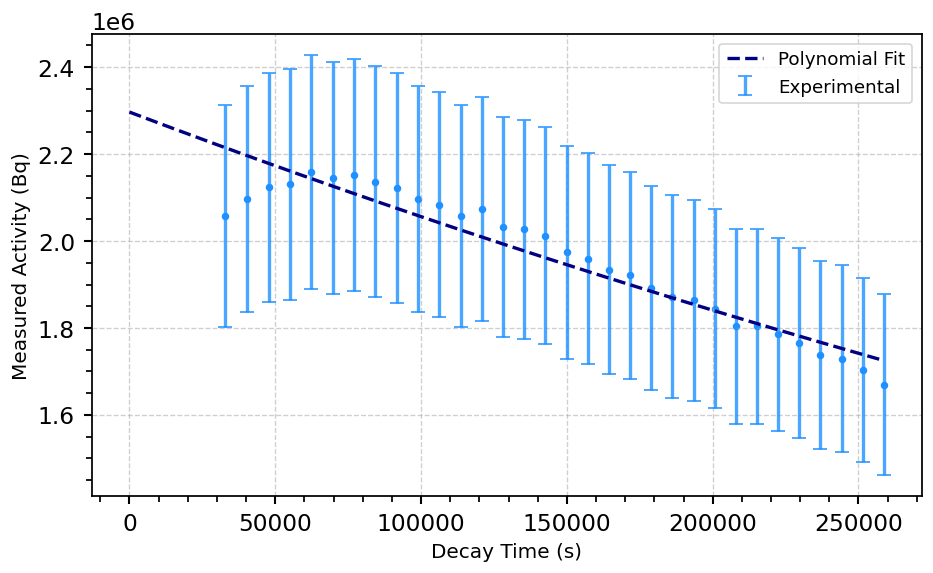


Analyzing: 156TB @ 1222.44 keV  →  156TB_1222.440_activity-time.png
Optimized Decay Parameters:
  Parameter 1: 2051729.9934 ± 112200.5038
  Parameter 2: 0.0000 ± 0.0000

📐 Jacobian condition number: 6.10e+23


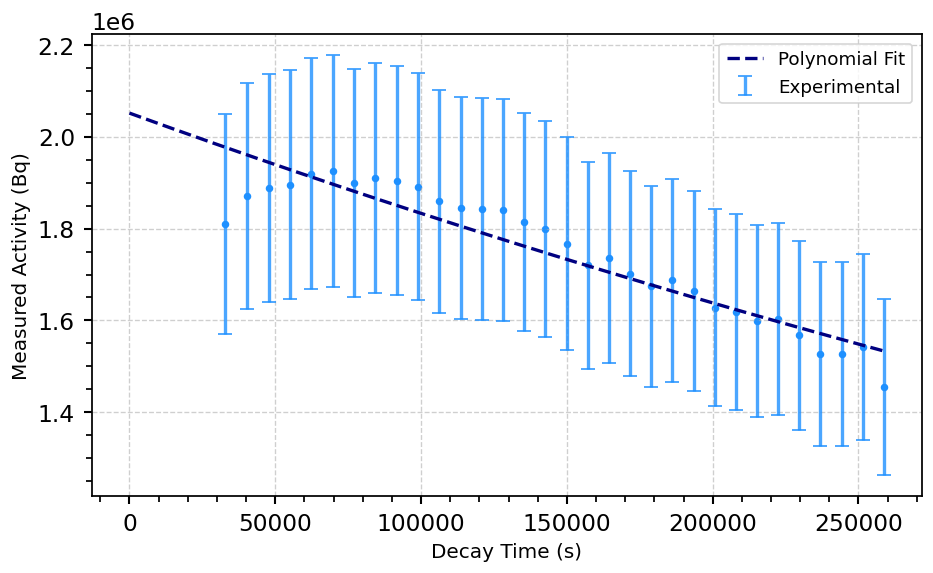

In [38]:
# Peform the decay analysis
se.process_decay_data(plot_directory=f'{output_dir}/decay_plots')

In [39]:
# Save the analysis-ready decay data to an xlsx
se.save_decay_data(f"{output_dir}/decay-analysis-results.xlsx")

💾 Results saved to: /content/outputs/decay-analysis-results.xlsx


'/content/outputs/decay-analysis-results.xlsx'

In [40]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive("/content/outputs", 'zip', "/content/outputs")

# Download it
files.download("/content/outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>